In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
# from scipy.ndimage import convolve
from cv2 import filter2D
from skimage.feature import peak_local_max

data_path = '../week2/data/'

# Helpting functions

In [18]:
def get_gauss_derivatives(t, trunc=5):
    """
    Returns Gaussian kernel and its derivatives up to the third order.

    Parameters:
    t (float): The variance of the Gaussian.
    trunc (float, optional): The truncation value for the kernel size. Defaults to 5.

    Returns:
    tuple: A tuple containing the kernels as numpy arrays.
    """
    s = np.sqrt(t)
    r = np.ceil(trunc * s)
    x = np.arange(-r, r + 1)
    g = np.exp(-x**2 / (2 * t))
    g = g / np.sum(g)
    dg = -(x / t) * g
    ddg = -g / t - (x / t) * dg
    dddg = -2 * dg / t - (x / t) * ddg
    return g, dg, ddg, dddg

def separable_filtering(image, kernelx, kernely):
    """
    Applies separable filtering to an image.

    Args:
        image: The input image to be filtered.
        kernelx: The kernel for first axis.
        kernely: The kernel for second axis.

    Returns:
        The filtered image.
    """
    kernelx = kernelx.reshape(1, -1)
    kernely = kernely.reshape(-1, 1)
    return filter2D(filter2D(image, -1, kernelx), -1, kernely)

# Initialize scale-space

In [25]:
# Load image
im = imread(data_path + 'test_blob_varying.png').astype(np.float32)

# Compute Gaussian derivatives
t = 4
g, _, ddg, _ = get_gauss_derivatives(t)

# Scale-space initialization
n = 300  # number of scales to consider
t_values = np.arange(1, n + 1) * t # scale values

# Print scale values
print(t_values)

# Compute scale-space volume
L_blob_vol = np.zeros(im.shape + (n,))

Lg = im # Create a copy of the image

[   4    8   12   16   20   24   28   32   36   40   44   48   52   56
   60   64   68   72   76   80   84   88   92   96  100  104  108  112
  116  120  124  128  132  136  140  144  148  152  156  160  164  168
  172  176  180  184  188  192  196  200  204  208  212  216  220  224
  228  232  236  240  244  248  252  256  260  264  268  272  276  280
  284  288  292  296  300  304  308  312  316  320  324  328  332  336
  340  344  348  352  356  360  364  368  372  376  380  384  388  392
  396  400  404  408  412  416  420  424  428  432  436  440  444  448
  452  456  460  464  468  472  476  480  484  488  492  496  500  504
  508  512  516  520  524  528  532  536  540  544  548  552  556  560
  564  568  572  576  580  584  588  592  596  600  604  608  612  616
  620  624  628  632  636  640  644  648  652  656  660  664  668  672
  676  680  684  688  692  696  700  704  708  712  716  720  724  728
  732  736  740  744  748  752  756  760  764  768  772  776  780  784
  788 

**t_values = np.arange(1, n + 1) * t**

- Generates a numpy array t_values containing scale values that will be used to modify the Gaussian kernel's variance (t). This array starts from t, incrementing by t for each scale, up to n * t.

- Generates a series of scale factors that progressively increase the smoothing effect.

**L_blob_vol = np.zeros(im.shape + (n,))**

- Initializes a 3D numpy array L_blob_vol with dimensions equal to the original image's dimensions plus an additional dimension for the scales (n). This array is initially filled with zeros.

- Serves as the container for the scale-space volume of the image. Each "slice" of this volume (along the third dimension) represents the image filtered at a different scale.

# Compute the scale-space volume

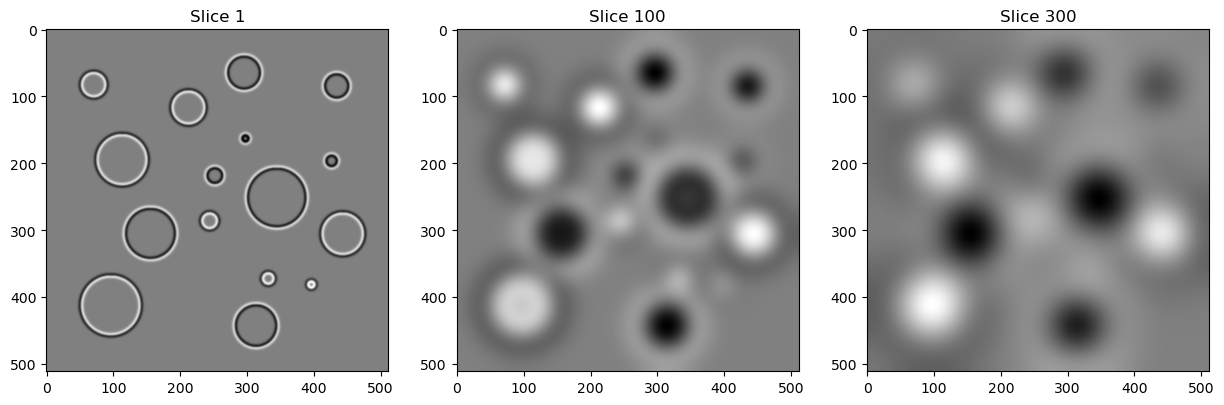

In [26]:
for i in range(0, n):
    L_blob_vol[:, :, i] = t_values[i] * (separable_filtering(Lg, g, ddg) +  
                                       separable_filtering(Lg, ddg, g))
    Lg = separable_filtering(Lg, g, g)

# Show 3 slices of the scale-space volume
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(L_blob_vol[:, :, 0], cmap='gray')
plt.title('Slice 1')
plt.subplot(132)
plt.imshow(L_blob_vol[:, :, 100], cmap='gray')
plt.title('Slice 100')
plt.subplot(133)
plt.imshow(L_blob_vol[:, :, 299], cmap='gray')
plt.title('Slice 300')
plt.show()

#### **L_blob_vol[:, :, i] = t_values[i] * (separable_filtering(Lg, g, ddg) +  separable_filtering(Lg, ddg, g))**

**L_blob_vol[:, :, i]**
- Assigns the computed value to the i-th "slice" of the 3D array L_blob_vol, which is the scale-space volume of the image. Each slice corresponds to the image processed at a specific scale.

**t_values[i]**
- Scales the filter response by the current scale factor, derived from t_values, which is an array of scale factors increasing linearly.
- **Multiplying by t_values[i] normalizes the response across scales**. This is crucial because the magnitude of the Laplacian of Gaussian (LoG) response to blobs decreases with increasing scale (blob size). Scaling by the factor ensures that blobs of all sizes contribute similarly to the final detection result, achieving scale invariance.

**separable_filtering(Lg, g, ddg)**
- **Applies a 2D filtering** operation in a separable manner using the Gaussian kernel g and its second derivative ddg. The **first kernel g is applied along one axis, and ddg along the other axis.**
- The Gaussian kernel smooths the image, while its second derivative responds strongly to changes in intensity, which are characteristic of blobs. Applying these filters separately along different axes is computationally efficient and approximates the LoG filter, which is known for its blob-detecting properties. This operation enhances regions in the image that correspond to potential blobs.
- By combining these separable filtering operations, the algorithm effectively enhances blob-like features in all directions, crucial for accurate blob detection.

#### **Lg = separable_filtering(Lg, g, g):**
- Applies a Gaussian filter (smoothing) to the image Lg for the next iteration. This operation uses the Gaussian kernel g for both axes, effectively smoothing the image.
- This step reduces high-frequency noise and details in the image, progressively focusing on larger-scale structures as the loop advances. By smoothing the image iteratively, the algorithm prepares it for detecting blobs at increasingly larger scales.

# Find maxima and visualize

[[412  97 267]
 [306 443 133]
 [196 114 191]
 [117 213  81]
 [ 83  71  45]
 [373 332  10]
 [287 245  19]
 [382 397   4]]


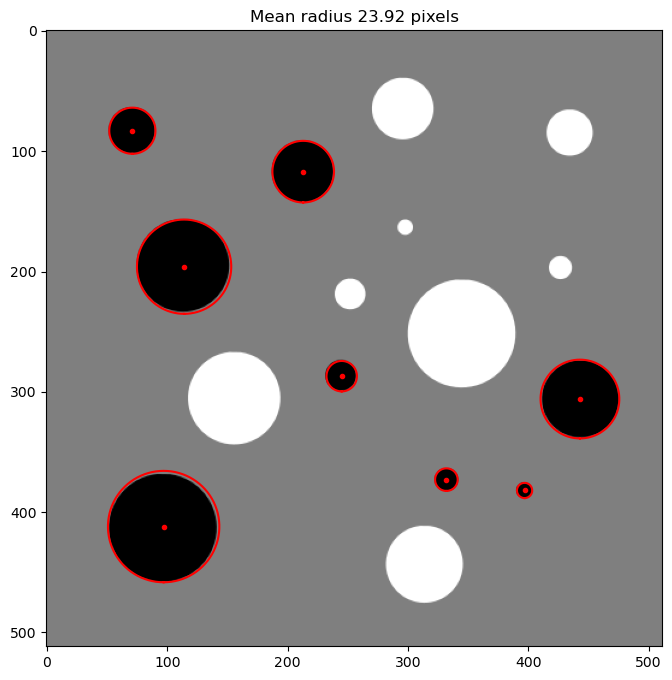

In [28]:
# Find maxima in scale-space
coord = peak_local_max(L_blob_vol, threshold_abs = 40)

# Show coords
print(coord)

# Visualize
theta = np.linspace(0, 2 * np.pi, 91, endpoint=True)
circ = np.array((np.cos(theta), np.sin(theta)))

blob_radii = np.sqrt(2 * t_values[coord[:,2]])
circ_y = np.outer(circ[0], blob_radii) + coord[:, 0]
circ_x = np.outer(circ[1], blob_radii) + coord[:, 1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im, cmap='gray')
ax.plot(coord[:, 1], coord[:, 0], '.r', circ_x, circ_y, 'r')
ax.set_title(f'Mean radius {blob_radii.mean():0.2f} pixels')
plt.show()

#### **coord = peak_local_max(L_blob_vol, threshold_abs = 40)**
- Identifies local maxima in the scale-space volume L_blob_vol that surpass a specified absolute threshold (threshold_abs = 40).

#### **blob_radii = np.sqrt(2 * t_values[coord[:,2]])**
- Calculates the radii of the detected blobs based on their scale (coord[:,2] indicates the scale at which each blob was detected).
- The radius is derived from the scale factor, ensuring that the visual representation of each blob corresponds to its actual size in the image. The formula reflects the relationship between the scale (variance) used in the Gaussian smoothing and the effective size of the blobs.

# Real scenario

In [22]:
def detect_fibers(im, diameter_limits, nr_steps, t_detection, thres):
    """
    Detects fibers in images by finding maxima of Gaussian smoothed image.

    Parameters:
    - im: numpy array, input image
    - diameter_limits: tuple, min and max of the fiber diameter (in pixels)
    - nr_steps: int, number of steps for scale variation
    - t_detection: float, scale parameter for fiber center detection
    - thres: float, blob magnitude threshold for fiber detection

    Returns:
    - coord: numpy array, coordinates of detected fiber centers
    - scale: numpy array, scale of detected fibers
    """
        
    t_values = np.linspace(diameter_limits[0]**2 / 8, 
                           diameter_limits[1]**2 / 8, nr_steps, endpoint=True)
    
    
    L_blob_vol = np.zeros(im.shape + (len(t_values),))
    for i, t in enumerate(t_values):
        g, dg, ddg, dddg = get_gauss_derivatives(t)
        L_blob_vol[:, :, i] = t * (separable_filtering(im, g, ddg) +  
                                   separable_filtering(im, ddg, g))
    
    # Detect fibre centers
    g, dg, ddg, dddg = get_gauss_derivatives(t_detection)
    Lg = separable_filtering(im, g, g)
    coord = peak_local_max(Lg, threshold_abs = thres)

    # Find coordinates and size (scale) of fibres
    magnitudeIm = L_blob_vol.min(axis = 2)
    scaleIm = L_blob_vol.argmin(axis = 2)
    
    scales = scaleIm[coord[:,0], coord[:,1]]
    magnitudes = - magnitudeIm[coord[:,0], coord[:,1]]
    idx = np.where(magnitudes > thres)[0]
    coord = coord[idx]
    scale = t_values[scales[idx]]
    return coord, scale

#### **t_values = np.linspace(diameter_limits[0]^2 / 8, diameter_limits[1]^2 / 8, nr_steps, endpoint=True)**
- Generates a sequence of t_values that represent the variance of the Gaussian kernel used for smoothing.
- The variance values are calculated based on the minimum and maximum diameters of the fibers, assuming the relationship between the fiber diameter and the Gaussian kernel's variance.
- **diameter_limits[0]^2 / 8** is a way to calculate the variance of the Gaussian kernel that is optimally matched to the expected size of the blobs (fibers) in the image. This ensures that the smoothing applied to the image is appropriate for enhancing the visibility of blobs with the specified diameter, making them more detectable by subsequent processing steps. 

#### **Computation of the scale-space volume**
- Constructs a scale-space volume L_blob_vol for the input image by applying Gaussian smoothing at different scales (t_values). Each slice of this volume corresponds to the image smoothed at a specific scale, enhanced for potential fiber detection.

In [23]:
def get_circles(coord, radii):
    """
        Compute coordinates for drawing circles around detected blobs.

    Parameters:
    coord (numpy.ndarray): Array of shape (n, 2) with the circle centers.
    scale (numpy.ndarray): Array of length n with circle radii.

    Returns:
    numpy.ndarray: Array of shape (n, 91) with the x-coordinates n circles.
    numpy.ndarray: Array of shape (n, 91) with the y-coordinates of n circles.
    """
    
    theta = np.linspace(0, 2 * np.pi, 91, endpoint=True)
    circ = np.array((np.cos(theta), np.sin(theta)))
    circ_y = np.outer(circ[0], radii) + coord[:, 0]
    circ_x = np.outer(circ[1], radii) + coord[:, 1]

    return circ_x, circ_y

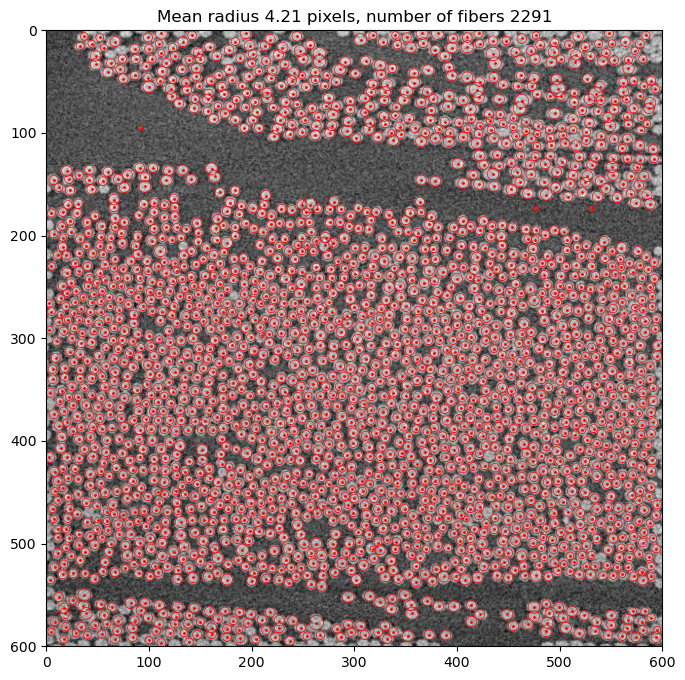

In [24]:
im = imread(data_path + 'CT_lab_med_res.png').astype(np.float32)/(2**16 - 1)

# Estimated diameter limits
diameter_limits = [5, 15]
nr_steps = 100

# Parameter for Gaussian to detect center point
t_detection = 7

# Parameter for finding maxima over Laplacian in scale-space
thres = 0.05

# Detect fibres
coord, scale = detect_fibers(im, diameter_limits, nr_steps, t_detection, thres)
radii = np.sqrt(2 * scale)

# Plot detected fibres
circ_x, circ_y = get_circles(coord, radii)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(im, cmap='gray')
ax.plot(coord[:,1], coord[:,0], 'r.', circ_x, circ_y, 'r', ms=2, lw=0.5)
ax.set_title(f'Mean radius {radii.mean():0.2f} pixels, number of fibers {len(radii)}')
ax.set_xlim(0, im.shape[1])
ax.set_ylim(im.shape[0], 0)
plt.show()